# Results Visualization Notebook

In [61]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

### Aggregate raw results

In [25]:
results_root = "results_R_35"
all_results = []

# ----------------------------
# Load all raw_results.csv
# ----------------------------
for learner in os.listdir(results_root):
    learner_dir = os.path.join(results_root, learner)
    if not os.path.isdir(learner_dir):
        continue

    for dim in os.listdir(learner_dir):
        dim_dir = os.path.join(learner_dir, dim)
        raw_path = os.path.join(dim_dir, "raw_results.csv")

        if not os.path.exists(raw_path):
            continue

        df = pd.read_csv(raw_path)
        df["learner"] = learner
        df["dimensionality"] = dim
        all_results.append(df)

all_df = pd.concat(all_results, ignore_index=True)

# Optional: clean dimensionality label
all_df["dimensionality"] = all_df["dimensionality"].str.replace("d", "")

print(all_df.head())

  learner  tuner  rep      pehe  pehe_plug dimensionality
0    x_cb  bayes    0  0.066510   0.189026              4
1    x_cb  bayes    1  0.171590   0.470938              4
2    x_cb  bayes    2  0.215037   0.453474              4
3    x_cb  bayes    3  0.162552   0.370131              4
4    x_cb  bayes    4  0.083686   0.231328              4


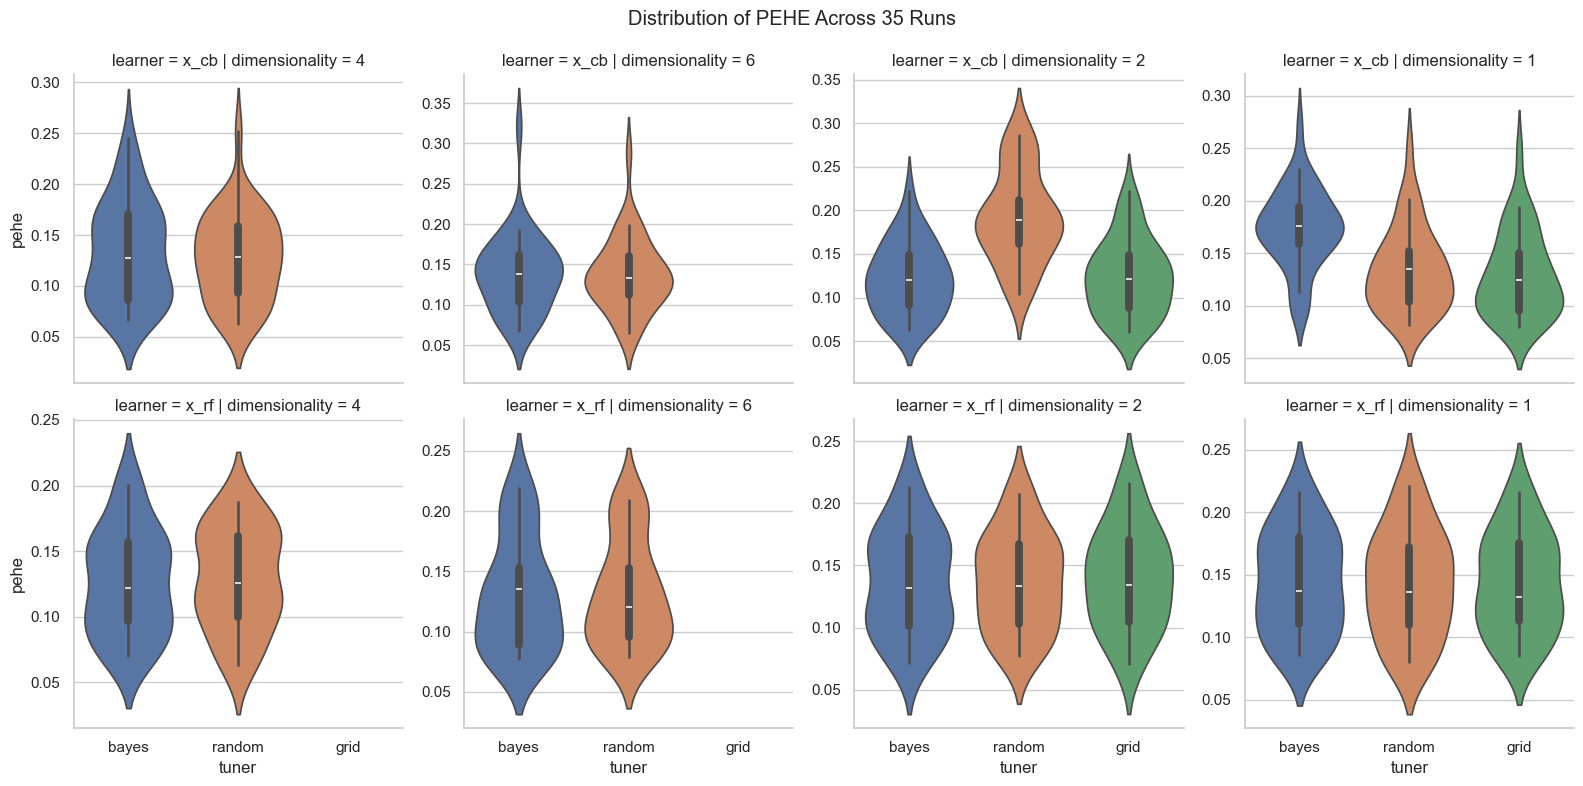

In [3]:
g = sns.catplot(
    data=all_df,
    x="tuner",
    y="pehe",
    hue="tuner",
    col="dimensionality",
    row="learner",
    kind="violin",
    sharey=False,
    height=4,
    aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of PEHE Across 35 Runs")
plt.show()

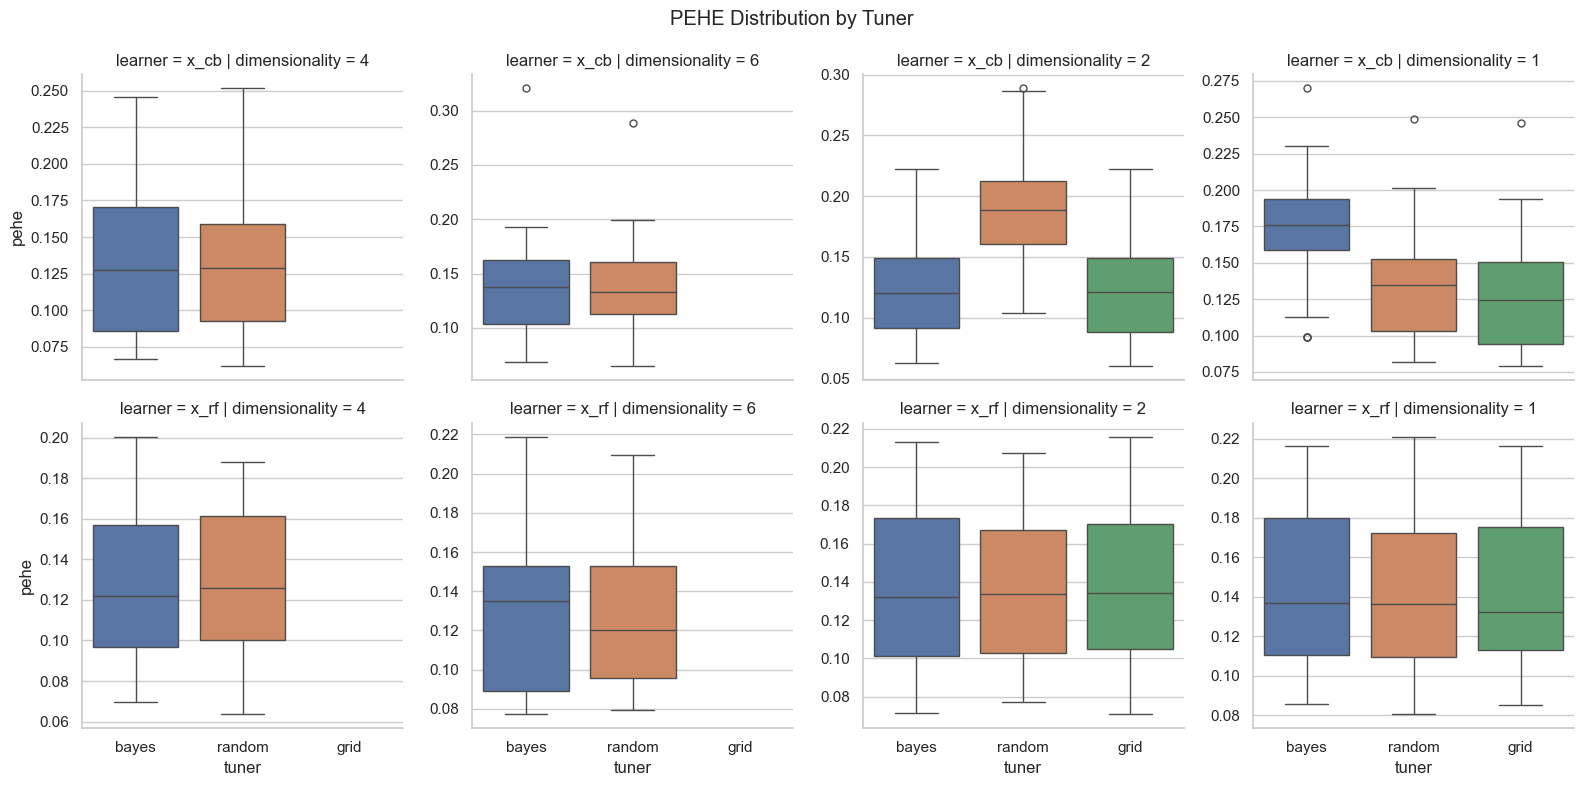

In [6]:
g = sns.catplot(
    data=all_df,
    x="tuner",
    y="pehe",
    col="dimensionality",
    row="learner",
    kind="box",
    hue="tuner",
    sharey=False,
    height=4,
    aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("PEHE Distribution by Tuner")
plt.show()

### KDE Plots

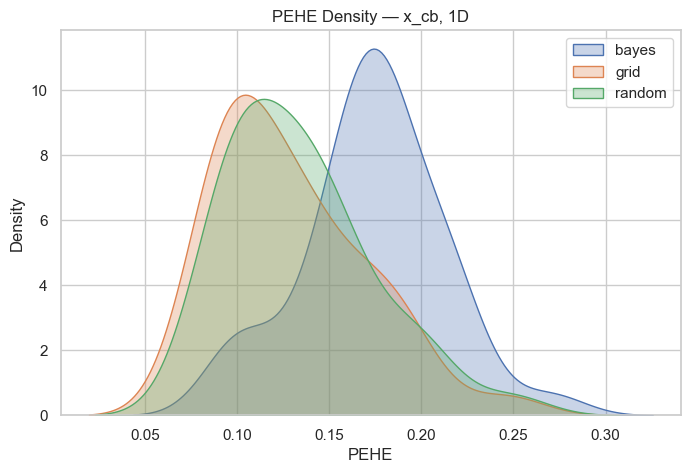

In [5]:
subset = all_df[
    (all_df["learner"] == "x_cb") &
    (all_df["dimensionality"] == "1")
]

plt.figure(figsize=(8,5))

for tuner in subset["tuner"].unique():
    sns.kdeplot(
        subset[subset["tuner"] == tuner]["pehe"],
        label=tuner,
        fill=True,
        alpha=0.3
    )

plt.title("PEHE Density — x_cb, 1D")
plt.xlabel("PEHE")
plt.legend()
plt.show()

In [26]:
# ----------------------------
# Generate KDE overlays
# ----------------------------
output_dir = "plots/kde_plots"
os.makedirs(output_dir, exist_ok=True)

for learner in all_df["learner"].unique():
    learner_df = all_df[all_df["learner"] == learner]

    for dim in sorted(learner_df["dimensionality"].unique(), key=int):
        subset = learner_df[learner_df["dimensionality"] == dim]

        plt.figure(figsize=(8, 5))

        for tuner in subset["tuner"].unique():
            tuner_data = subset[subset["tuner"] == tuner]["pehe"]

            sns.kdeplot(
                tuner_data,
                label=tuner,
                fill=True,
                alpha=0.3
            )

        plt.title(f"PEHE Density — {learner}, {dim}D")
        mean_val = tuner_data.mean()
        plt.axvline(mean_val, linestyle="--", alpha=0.6)
        plt.xlabel("PEHE")
        plt.ylabel("Density")
        plt.legend(title="Tuner")

        plt.tight_layout()
        plt.savefig(f"{output_dir}/kde_{learner}_{dim}D.png", dpi=300)
        plt.close()

print("All KDE plots saved.")

All KDE plots saved.


In [27]:

# ----------------------------
# Create plots
# ----------------------------
output_dir = "plots/kde_vertical_comparison"
os.makedirs(output_dir, exist_ok=True)

for learner in all_df["learner"].unique():
    learner_df = all_df[all_df["learner"] == learner]

    for dim in sorted(learner_df["dimensionality"].unique(), key=int):
        subset = learner_df[learner_df["dimensionality"] == dim]

        # Determine shared x-axis range
        x_min = min(subset["pehe"].min(), subset["pehe_plug"].min())
        x_max = max(subset["pehe"].max(), subset["pehe_plug"].max())
        x_padding = 0.05 * (x_max - x_min)

        fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

        tuners = subset["tuner"].unique()
        palette = sns.color_palette("colorblind", n_colors=len(tuners))

        # ---------------- TOP: PEHE ----------------
        for i, tuner in enumerate(tuners):
            data = subset[subset["tuner"] == tuner]["pehe"]
            mean_val = data.mean()

            sns.kdeplot(
                data,
                ax=axes[0],
                label=tuner,
                fill=True,
                alpha=0.3,
                color=palette[i]
            )

            axes[0].axvline(
                mean_val,
                linestyle="--",
                linewidth=1.5,
                color=palette[i]
            )

        axes[0].set_title("True PEHE")
        axes[0].set_ylabel("Density")

        # ---------------- BOTTOM: Plug-in PEHE ----------------
        for i, tuner in enumerate(tuners):
            data = subset[subset["tuner"] == tuner]["pehe_plug"]
            mean_val = data.mean()

            sns.kdeplot(
                data,
                ax=axes[1],
                label=tuner,
                fill=True,
                alpha=0.3,
                color=palette[i]
            )

            axes[1].axvline(
                mean_val,
                linestyle="--",
                linewidth=1.5,
                color=palette[i]
            )
            

        axes[1].set_title("Plug-in PEHE")
        axes[1].set_xlabel("Error")
        axes[1].set_ylabel("Density")

        # Shared x limits
        axes[0].set_xlim(x_min - x_padding, x_max + x_padding)
        

        # Single legend
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, title="Tuner", loc="upper right", ncol=len(tuners))

        fig.suptitle(f"{learner.upper()} — {dim}D", fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])

        plt.savefig(
            f"{output_dir}/kde_{learner}_{dim}D_vertical.png",
            dpi=300,
            bbox_inches="tight"
        )
        plt.close()

print("All vertical comparison plots saved.")

All vertical comparison plots saved.


### PEHE and PEHE Plug-in Correlations

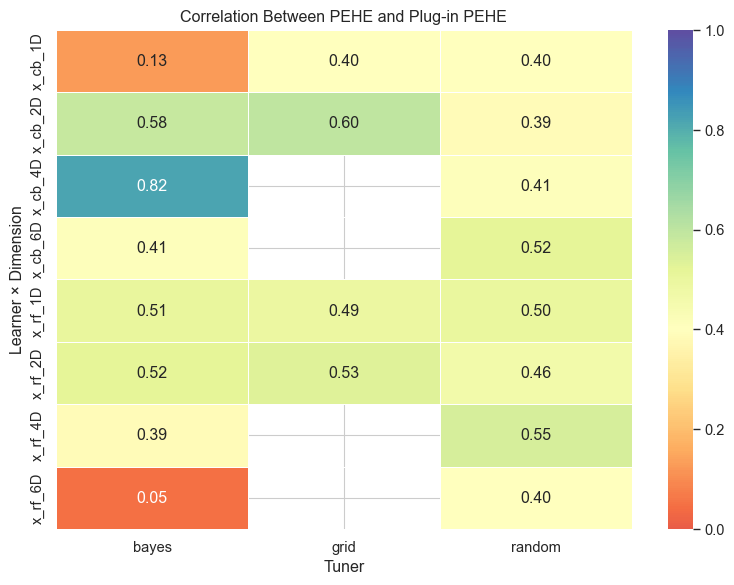

In [47]:

# ----------------------------
# Compute correlations
# ----------------------------
corr_records = []

for learner in all_df["learner"].unique():
    learner_df = all_df[all_df["learner"] == learner]

    for dim in sorted(learner_df["dimensionality"].unique(), key=int):
        subset = learner_df[learner_df["dimensionality"] == dim]

        for tuner in subset["tuner"].unique():
            tuner_df = subset[subset["tuner"] == tuner]

            # Spearman (ranking consistency)
            corr, _ = spearmanr(
                tuner_df["pehe"],
                tuner_df["pehe_plug"]
            )

            corr_records.append({
                "learner_dim": f"{learner}_{dim}D",
                "tuner": tuner,
                "correlation": corr
            })

corr_df = pd.DataFrame(corr_records)

# ----------------------------
# Pivot for heatmap
# ----------------------------
heatmap_df = corr_df.pivot(
    index="learner_dim",
    columns="tuner",
    values="correlation"
)

# Optional: sort rows nicely
heatmap_df = heatmap_df.sort_index()

# ----------------------------
# Plot heatmap
# ----------------------------
plt.figure(figsize=(8, 6))
sns.set_context("paper", font_scale=1.2)

sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".2f",
    cmap="Spectral",
    center=0.4,          # centers color around strong correlation
    vmin=0,
    vmax=1,
    linewidths=0.5
)

plt.title("Correlation Between PEHE and Plug-in PEHE")
plt.xlabel("Tuner")
plt.ylabel("Learner × Dimension")

plt.tight_layout()
plt.savefig("plots/pehe_proxy_correlation_heatmap.png", dpi=300)
plt.show()

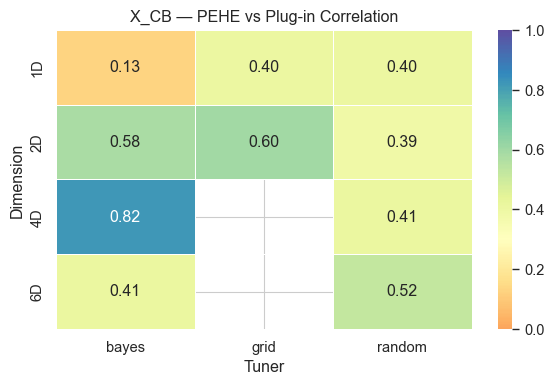

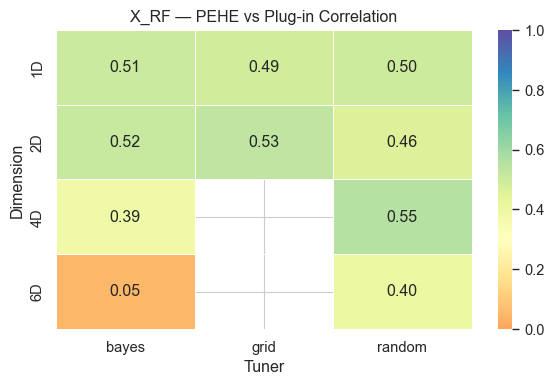

In [ ]:
# ----------------------------
# Compute correlations
# ----------------------------
corr_records = []

for learner in all_df["learner"].unique():
    learner_df = all_df[all_df["learner"] == learner]

    for dim in sorted(learner_df["dimensionality"].unique(), key=int):
        subset = learner_df[learner_df["dimensionality"] == dim]

        for tuner in subset["tuner"].unique():
            tuner_df = subset[subset["tuner"] == tuner]

            corr, _ = spearmanr(
                tuner_df["pehe"],
                tuner_df["pehe_plug"]
            )

            corr_records.append({
                "learner": learner,
                "dimension": f"{dim}D",
                "tuner": tuner,
                "correlation": corr
            })

corr_df = pd.DataFrame(corr_records)


# ----------------------------
# Plot separate heatmap per learner
# ----------------------------
os.makedirs("plots", exist_ok=True)

sns.set_context("paper", font_scale=1.2)

for learner in corr_df["learner"].unique():

    learner_df = corr_df[corr_df["learner"] == learner]

    heatmap_df = learner_df.pivot(
        index="dimension",
        columns="tuner",
        values="correlation"
    )

    # Ensure correct row ordering
    heatmap_df = heatmap_df.reindex(["1D", "2D", "4D", "6D"])

    plt.figure(figsize=(6, 4))

    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".2f",
        cmap="Spectral",
        center=0.3,
        vmin=0,
        vmax=1,
        linewidths=0.5
    )

    plt.title(f"{learner.upper()} — PEHE vs Plug-in Correlation")
    plt.xlabel("Tuner")
    plt.ylabel("Dimension")

    plt.tight_layout()
    plt.savefig(f"plots/pehe_proxy_corr_{learner}.png", dpi=300)
    plt.show()

### Boxplots

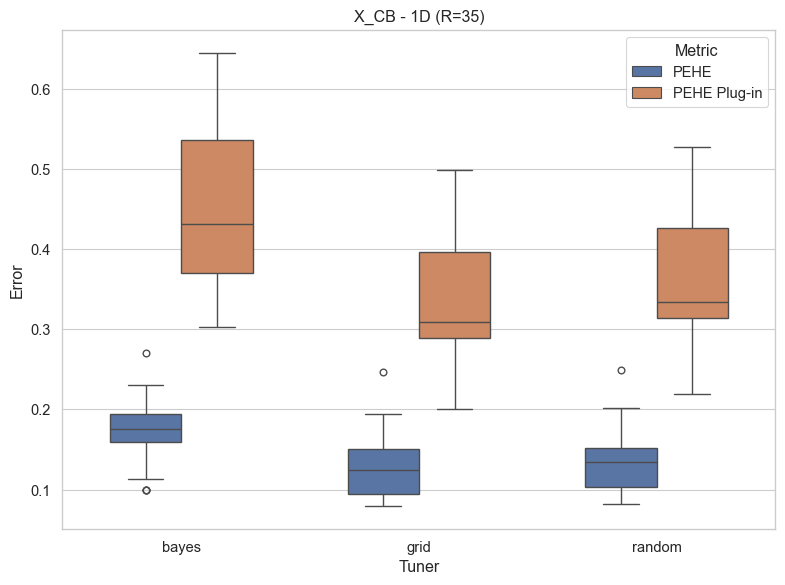

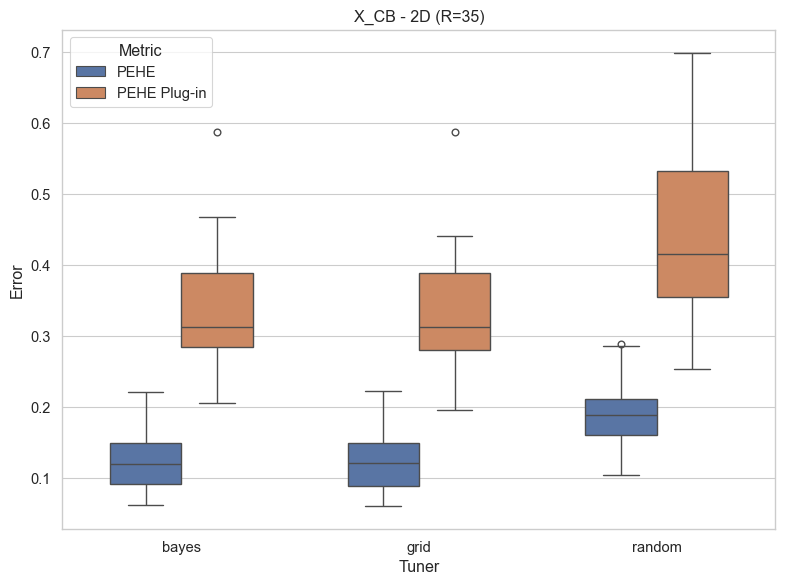

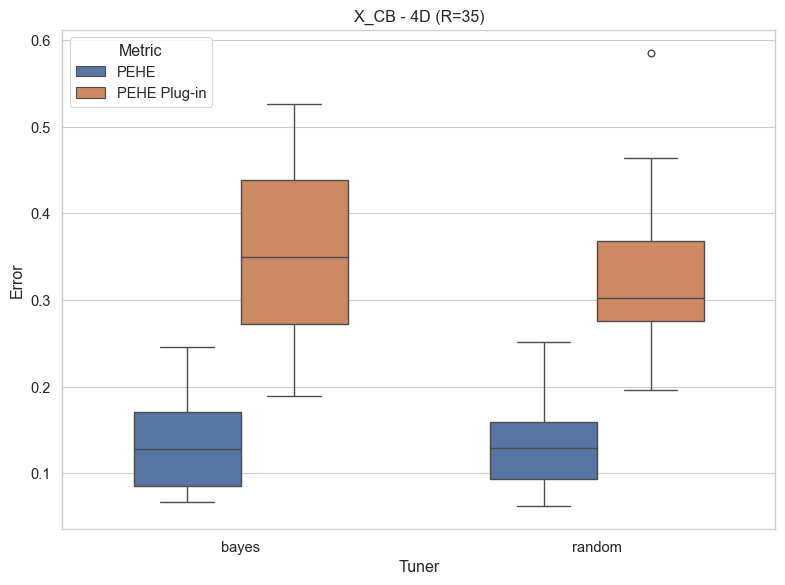

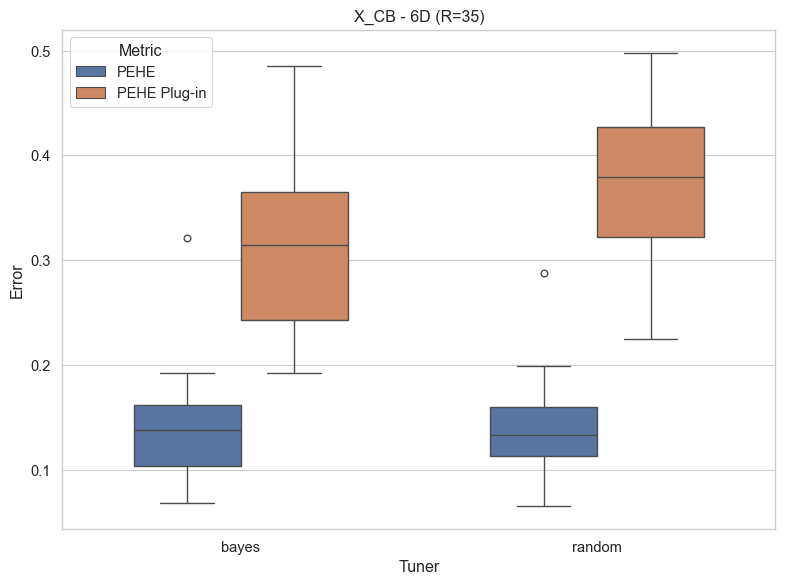

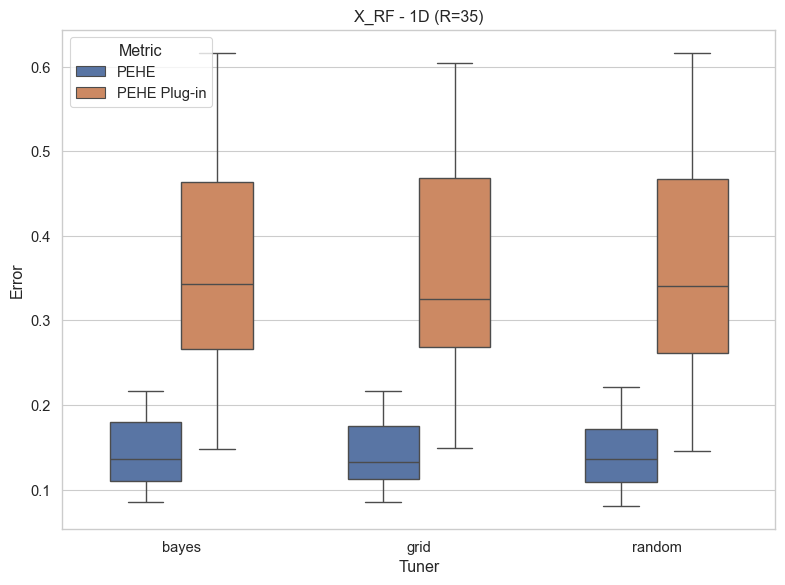

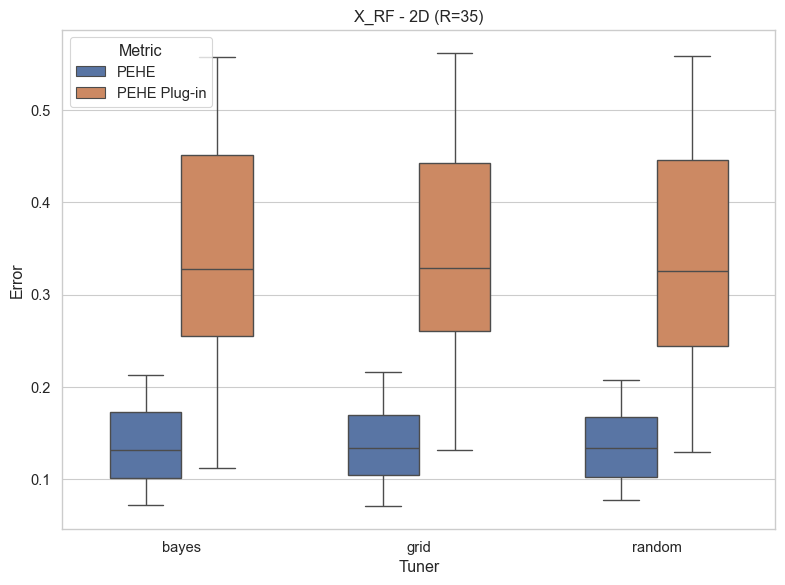

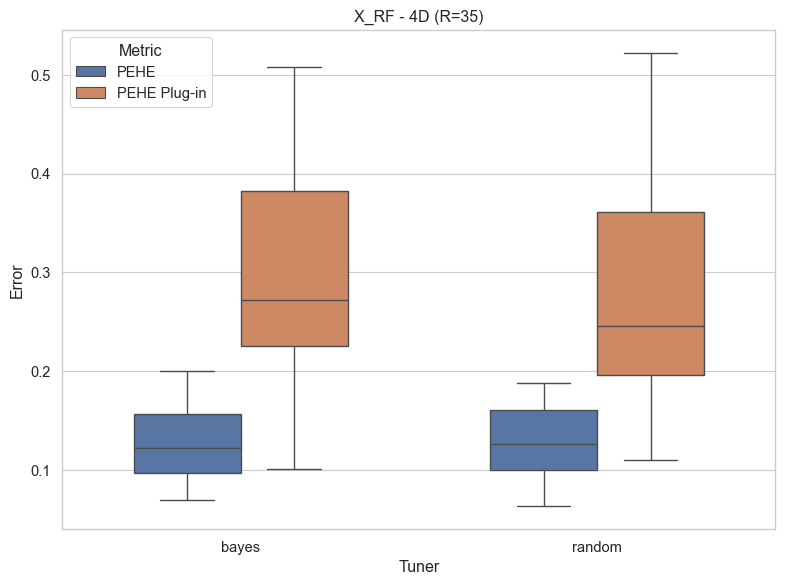

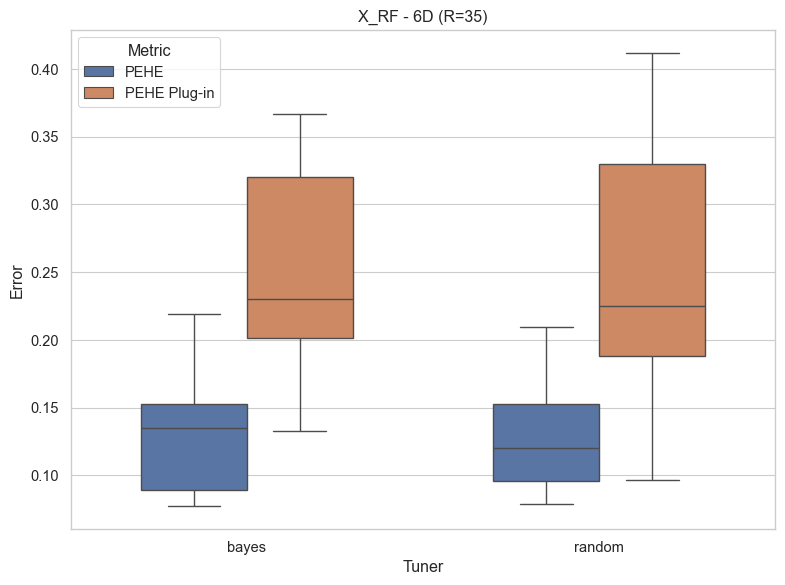

In [ ]:



for learner in all_df["learner"].unique():
    learner_df = all_df[all_df["learner"] == learner]

    for dim in sorted(learner_df["dimensionality"].unique(), key=int):
        subset = learner_df[learner_df["dimensionality"] == dim].copy()

        # Reshape for seaborn (long format)
        long_df = subset.melt(
            id_vars=["tuner"],
            value_vars=["pehe", "pehe_plug"],
            var_name="metric",
            value_name="value"
        )

        # Rename metrics for cleaner legend
        long_df["metric"] = long_df["metric"].map({
            "pehe": "PEHE",
            "pehe_plug": "PEHE Plug-in"
        })

        plt.figure(figsize=(8, 6))

        sns.boxplot(
            data=long_df,
            x="tuner",
            y="value",
            hue="metric",
            width=0.6
        )

        plt.title(f"{learner.upper()} - {dim}D (R={subset.shape[0]//len(subset['tuner'].unique())})")
        plt.xlabel("Tuner")
        plt.ylabel("Error")
        plt.legend(title="Metric")

        plt.tight_layout()
        plt.savefig(
            f"{output_dir}/boxplot_{learner}_{dim}D.png",
            dpi=300,
            bbox_inches="tight"
        )

Available tuners: ['bayes', 'grid', 'random']
Available learners: ['x_cb', 'x_rf']


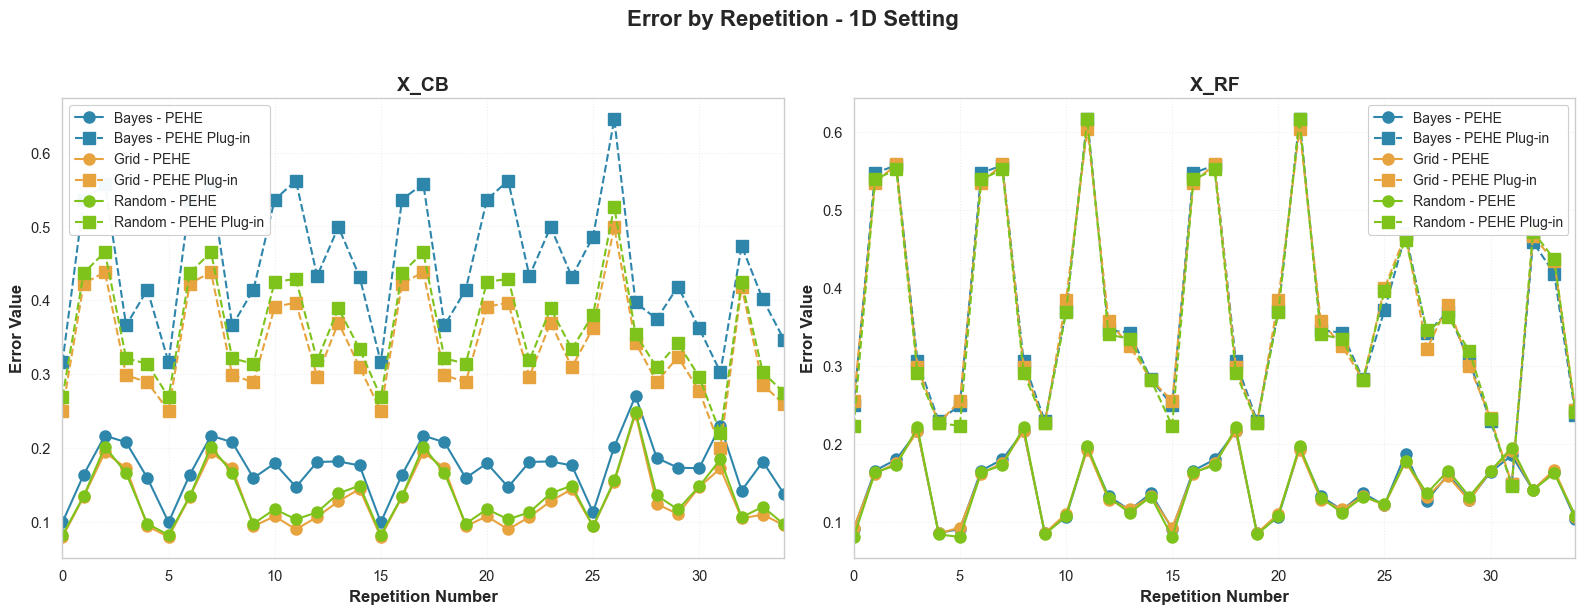

Saved: plots/error_by_repetition/error_by_repetition_1D.png


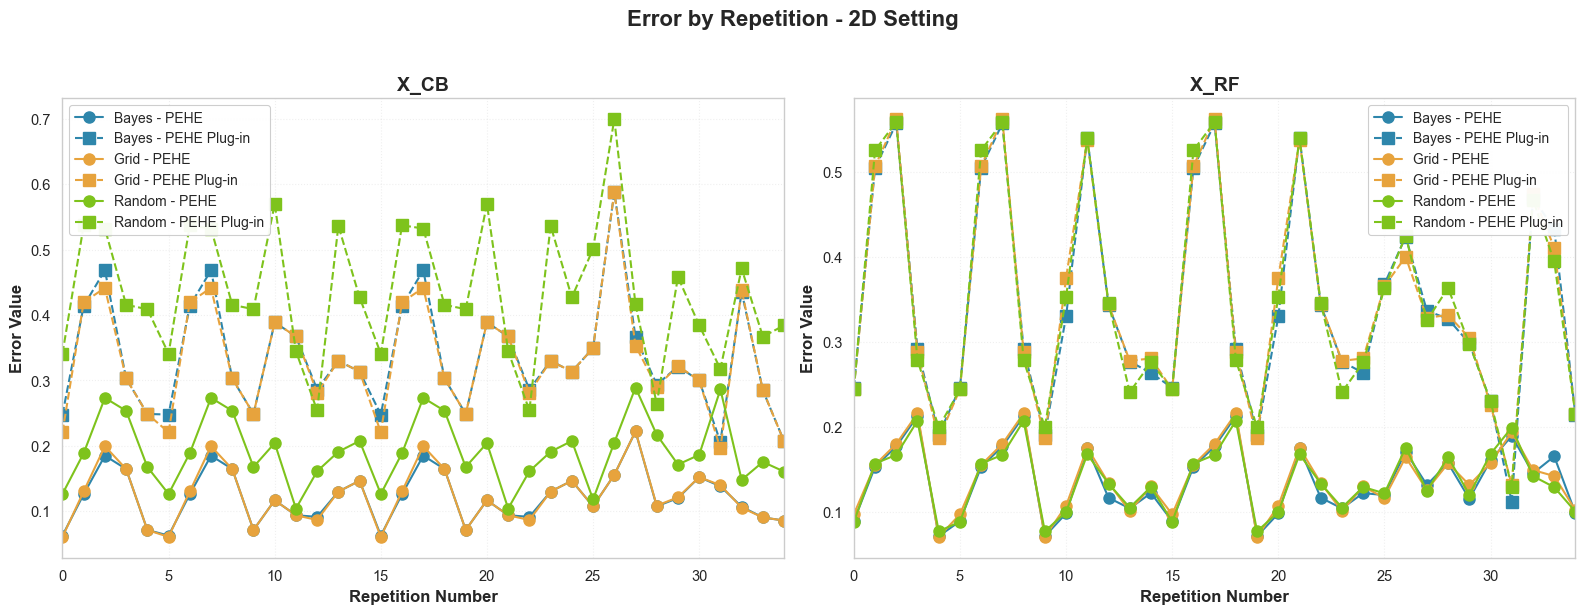

Saved: plots/error_by_repetition/error_by_repetition_2D.png


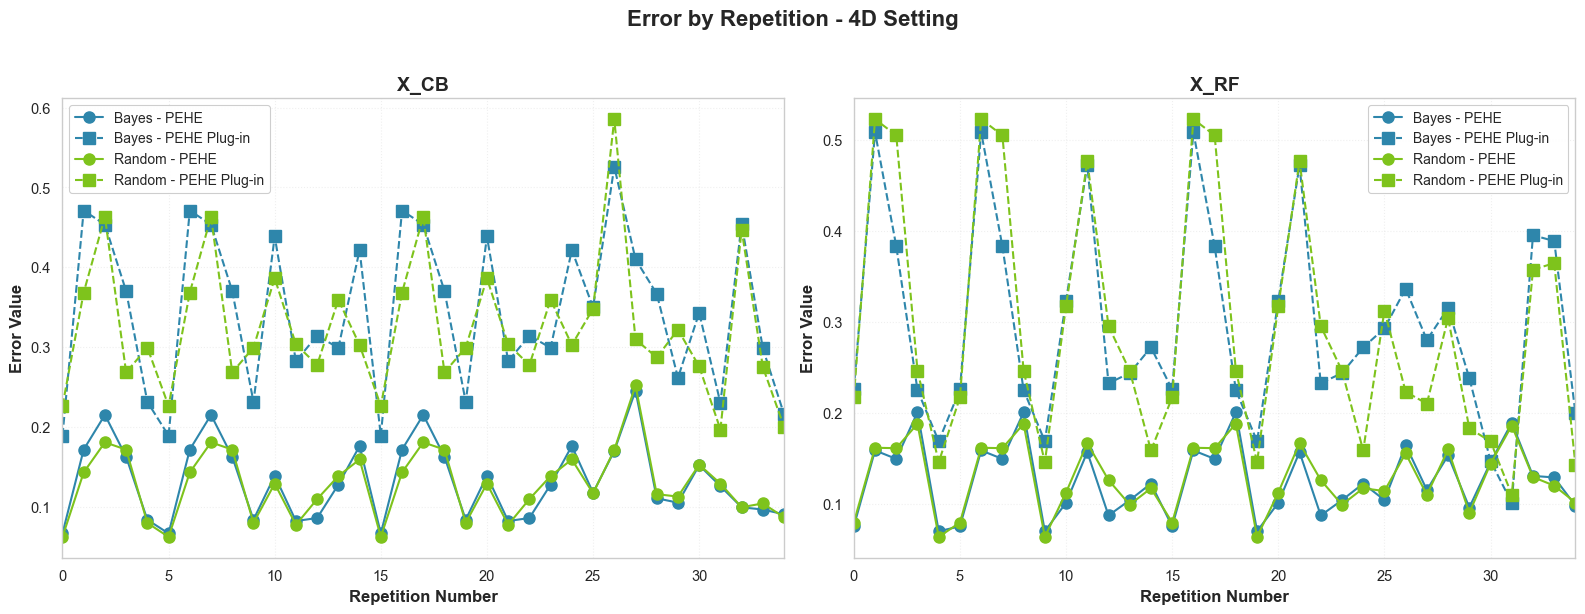

Saved: plots/error_by_repetition/error_by_repetition_4D.png


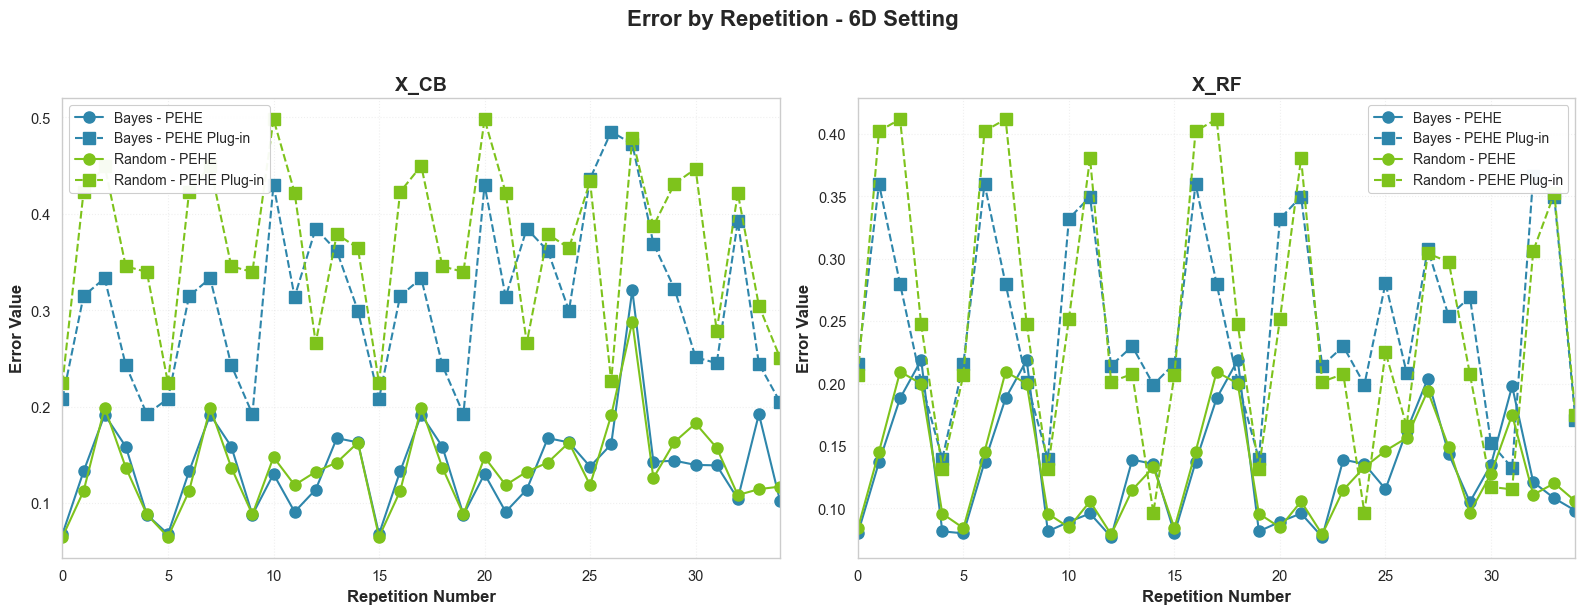

Saved: plots/error_by_repetition/error_by_repetition_6D.png


In [60]:

output_dir = "plots/error_by_repetition"
os.makedirs(output_dir, exist_ok=True)

# Define colors for tuners
tuner_colors = {
    'bayes': '#2E86AB',
    'grid': "#E7A33D",
    'random': "#7EC31C"
}

# Get all unique tuners in the data
available_tuners = sorted(all_df['tuner'].unique())
print(f"Available tuners: {available_tuners}")

# Get all unique learners (models)
models = sorted(all_df['learner'].unique())
print(f"Available learners: {models}")

# Create plots for each dimensionality setting
for setting in sorted(all_df["dimensionality"].unique()):
    setting_data = all_df[all_df['dimensionality'] == setting]
    
    if len(setting_data) == 0:
        print(f"No data for {setting}, skipping...")
        continue
    
    # Create figure with 2 subplots (or adjust depending on number of learners)
    fig, axes = plt.subplots(1, len(models), figsize=(8 * len(models), 6))
    if len(models) == 1:
        axes = [axes]  # ensure axes is iterable
    
    fig.suptitle(f'Error by Repetition - {setting}D Setting', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    for idx, model in enumerate(models):
        ax = axes[idx]
        model_data = setting_data[setting_data['learner'] == model]
        
        if len(model_data) == 0:
            ax.text(0.5, 0.5, f'No data for {model}', 
                   ha='center', va='center', transform=ax.transAxes)
            continue
        
        # Plot for each tuner
        for tuner in available_tuners:
            tuner_data = model_data[model_data['tuner'] == tuner].sort_values('rep')
            
            if len(tuner_data) == 0:
                continue
            
            color = tuner_colors.get(tuner, '#666666')
            
            # Plot PEHE with solid line
            ax.plot(tuner_data['rep'], tuner_data['pehe'], 
                    color=color, linestyle='-', linewidth=1.5, 
                    marker='o', markersize=8, 
                    label=f'{tuner.capitalize()} - PEHE')
            
            # Plot PEHE Plug-in with dashed line
            ax.plot(tuner_data['rep'], tuner_data['pehe_plug'], 
                    color=color, linestyle='--', linewidth=1.5, 
                    marker='s', markersize=8, 
                    label=f'{tuner.capitalize()} - PEHE Plug-in')
        
        ax.set_title(f'{model.upper()}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Repetition Number', fontsize=12, fontweight='bold')
        ax.set_ylabel('Error Value', fontsize=12, fontweight='bold')
        #ax.set_xticks(range(0, 35))  # adjust depending on your repetitions
        ax.set_xticks(range(0, 35, 5))  # every 5 repetitions
        ax.set_xlim(0, 34)  # ensure the full range is shown
        ax.legend(loc='best', fontsize=10, framealpha=0.95)
        ax.grid(True, alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    filename = f'{output_dir}/error_by_repetition_{setting}D.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")